In [139]:
import torch
from torch import nn # contains nn framework

from torch.utils.data import DataLoader # Split data into batches

import torchvision
from torchvision import datasets # import fashionMNIST data for use
from torchvision import transforms # to manipulate data for use in model
from torchvision.transforms import ToTensor # to have data in tensor format

import matplotlib.pyplot as plt # Plot data

import requests # to save and load model to designated path
from pathlib import Path

from timeit import default_timer as timer # To time training and evaluation of model

from tqdm.auto import tqdm # progress bar

import random

try:
  import torchmetrics, mlxtend
  assert int(mlxtend.__version__.split(".")[1] >= 19, "mlxtend version should be 0.19.0 or higher")
except:
  !pip install -q torchmetrics -U mlxtend
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")

from torchmetrics import ConfusionMatrix # To use a confusion matrix to evaluate model
from mlxtend.plotting import plot_confusion_matrix

print(torch.__version__)
print(torchvision.__version__)

mlxtend version: 0.23.3
2.5.1+cu121
0.20.1+cu121


In [140]:
# Device agnostic code
device  = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

##Splitting data into training and testing sets

In [141]:
# Set up training data
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

# Set up testing data
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

# print length of each dataset
len(train_data), len(test_data)

(60000, 10000)

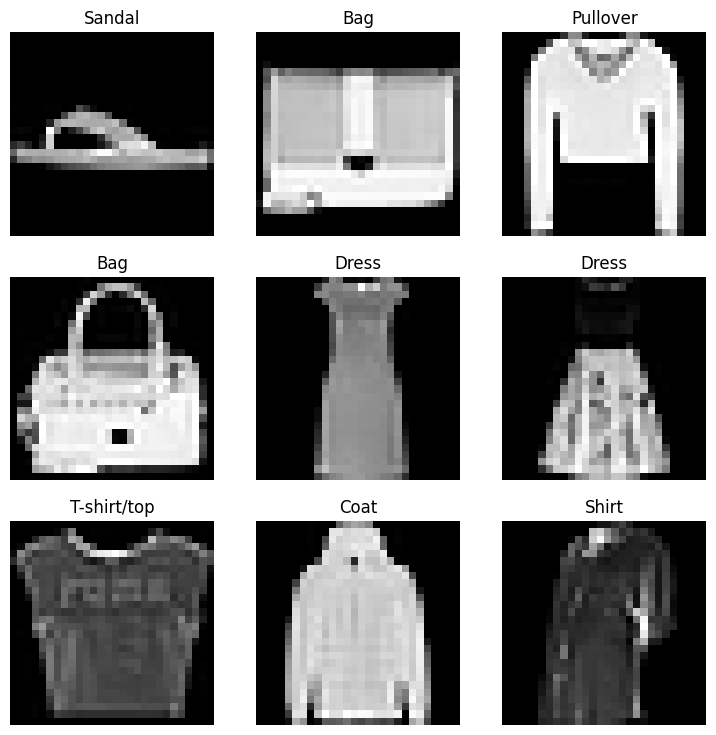

In [142]:
# list of class names in FashionMNIST
class_names = train_data.classes

# Visualize samples of data to ensure proper installation
fig = plt.figure(figsize=(9,9))
rows, cols = 3, 3
for i in range(1, rows*cols+1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols,i)
  plt.imshow(img.squeeze(), cmap="gray")
  plt.title(class_names[label])
  plt.axis(False)

In [143]:
# Setup batch size
BATCH_SIZE = 32

# Turn data into batches
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              shuffle=False)

print(f"Length of train_dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test_dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Length of train_dataloader: 1875 batches of 32
Length of test_dataloader: 313 batches of 32


## Defining model

In [144]:
# Create a convolutional neural network (CNN)
class FashionMNISTModel(nn.Module):
  """
  Replicates Tiny VGG architecture
  """

  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*7*7,
                  out_features=output_shape)
    )


  def forward(self, x: torch.Tensor):
    #print(f"Input shape: {x.shape}")
    x = self.conv_block_1(x)
    #print(f"Block 1 output shape: {x.shape}")
    x = self.conv_block_2(x)
    #print(f"Block 1 output shape: {x.shape}")
    x = self.classifier(x)
    #print(f"Output shape: {x.shape}")
    return x

# Initialize and instance of model
main_model = FashionMNISTModel(input_shape=1, # input is a 28x28 image
                               hidden_units=10, # 10 hidden units per layer
                               output_shape=len(class_names)) # output for each of the labels in FashionMNIST


### Defining loss function, optimizer and evaluation functions

In [145]:
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=main_model.parameters(),
                            lr=0.1)

In [146]:
def calc_train_time(start: float, end: float):
  """Calculates total train time of model

  Args:
    start (float): Start time of training/evaluation loop
    end (float):  End time of training/evaluation loop

  Returns:
    [float]: Total time of training/evaluation loop
  """
  total_time = end - start
  return total_time

In [147]:
def calc_accuracy(data_pred: torch.Tensor, data_true: torch.Tensor):
  """Calculates accuracy for model training and testing
  Args:
    data_pred (torch.Tensor): Predictions made by the model
    data_true (torch.Tensor): The true data labels that are to be compared to the predictions of the model

  Returns:
    [torch.float]: Accuracy value of predictions compared to the true labels in percentage form
  """
  acc = ( (torch.eq(data_true, data_pred).sum().item()) / len(data_pred)) * 100
  return acc

##Training model

In [148]:
# Training and testing loop
torch.manual_seed(100)
torch.cuda.manual_seed(100)

train_time_start = timer() # start timer

epochs = 5

for epoch in tqdm(range(epochs)):

  print(f"Epoch: {epoch+1} =================================")

### Testing
  main_model.train()
  train_loss = 0
  train_acc = 0
  for batch, (X, y) in enumerate(train_dataloader):

    # Put data on target device
    X, y = X.to(device), y.to(device)

    # Forward Pass
    y_logits = main_model(X)

    # Calculate and accumulate loss/acc
    loss = loss_fn(y_logits, y)
    train_loss += loss
    train_acc += calc_accuracy(data_pred=y_logits.argmax(dim=1), # converts raw logits to prediction labels
                               data_true=y)

    # Reset gradients
    optimizer.zero_grad()

    # Backpropagation
    loss.backward()

    # Stochastic gradient descent (SGD)
    optimizer.step()

  # Find average train loss and acc over entire dataset
  train_loss /= len(train_dataloader)
  train_acc /= len(train_dataloader)
  print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}%")

### Testing
  main_model.eval()
  with torch.inference_mode():
    test_loss = 0
    test_acc = 0
    for batch, (X, y) in enumerate(test_dataloader):

      # Put data on target device
      X, y = X.to(device), y.to(device)

      # Forward Pass
      test_logits = main_model(X)

      # Calculate and accumulate loss/acc
      loss = loss_fn(test_logits, y)
      test_loss += loss
      test_acc += calc_accuracy(data_pred=test_logits.argmax(dim=1), # converts raw logits to prediction labels
                               data_true=y)

    #  Find average test loss and acc over entire dataset
    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)
    print(f"Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%\n")



train_time_end = timer() # stop timer



  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 =================================
Train loss: 0.56443 | Train acc: 79.58%
Test loss: 0.39593 | Test acc: 85.50%

Epoch: 2 =================================
Train loss: 0.34558 | Train acc: 87.45%
Test loss: 0.33929 | Test acc: 87.73%

Epoch: 3 =================================
Train loss: 0.30466 | Train acc: 89.00%
Test loss: 0.31465 | Test acc: 88.99%

Epoch: 4 =================================
Train loss: 0.28512 | Train acc: 89.65%
Test loss: 0.29341 | Test acc: 89.61%

Epoch: 5 =================================
Train loss: 0.27029 | Train acc: 90.17%
Test loss: 0.29387 | Test acc: 89.66%



In [149]:
total_train_time = calc_train_time(start=train_time_start, end=train_time_end)
if total_train_time >= 60:
  total_train_time /= 60
  print(f"Training model took: {total_train_time:.2f} minutes")
else:
  print(f"Training model took: {total_train_time:.2f} seconds")

Training model took: 4.72 minutes


##Testing model

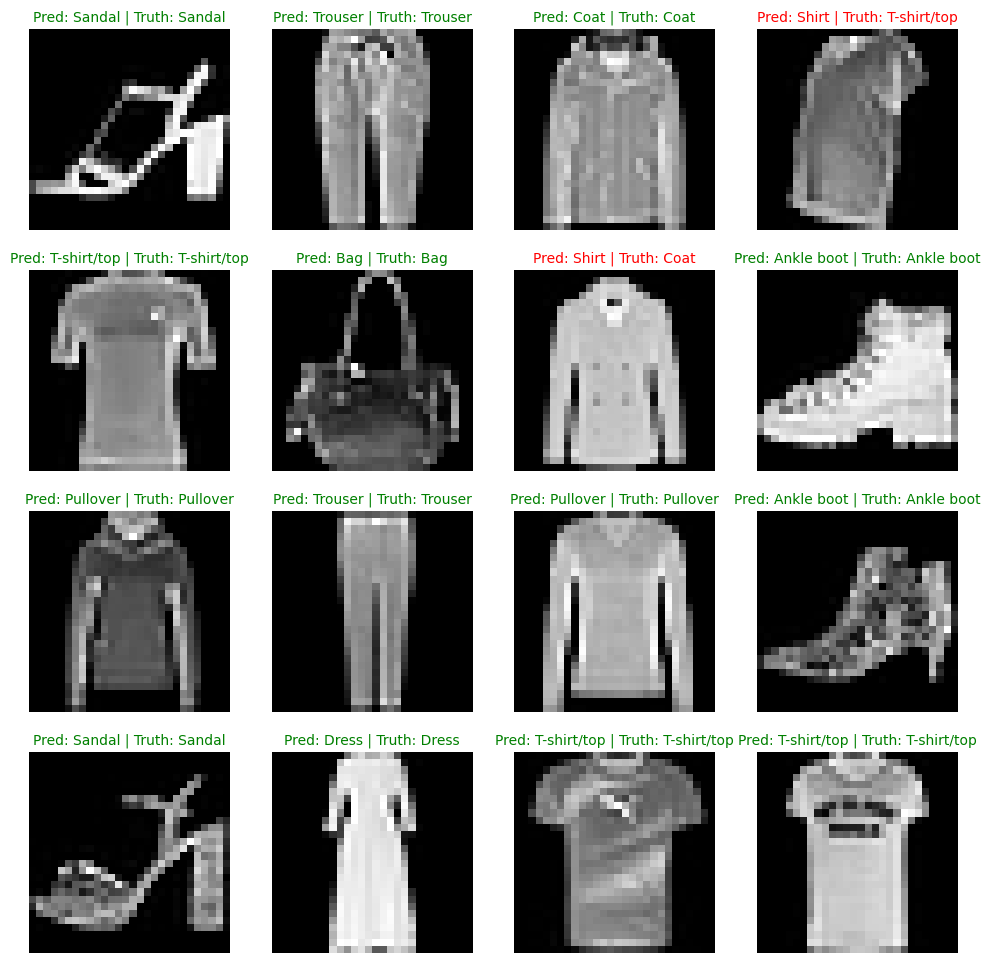

In [154]:
# Make test samples
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=16):
  test_samples.append(sample)
  test_labels.append(label)


# Make predictions
pred_probs = []
main_model.to(device)
main_model.eval()
with torch.inference_mode():
  for sample in test_samples:

    sample = torch.unsqueeze(sample, dim=0).to(device)

    pred_logit = main_model(sample)
    pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
    pred_probs.append(pred_prob.cpu())

pred_probs = torch.stack(pred_probs)

# Convert prediction probabilites to labels
pred_classes = pred_probs.argmax(dim=1)
pred_classes

# Plot random predictions (re-run this cell for different images and predictions)
plt.figure(figsize=(12,12))

for i, sample in enumerate(test_samples):

  # 4x4 matrix of images
  plt.subplot(4, 4, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction label in text form
  pred_label = class_names[pred_classes[i]]

  # Get the truth label in test form
  truth_label = class_names[test_labels[i]]

  # Create a title for the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # green if correct and red if incorrect
  if pred_label == truth_label:
    plt.title(title_text, fontsize=10, c="g")
  else:
    plt.title(title_text, fontsize=10, c="r")

  plt.axis(False)

### Using a confusion matrix

In [151]:
# Make predictions
y_preds = []
main_model.eval()
with torch.inference_mode():
  for (X, y) in tqdm(test_dataloader):
    X, y = X.to(device), y.to(device)
    y_logits = main_model(X)
    y_pred = torch.softmax(y_logits.squeeze(), dim=0).argmax(dim=1) # logits -> labels
    y_preds.append(y_pred.cpu()) # put label on cpu before appending
y_pred_tensor = torch.cat(y_preds)# Concatenate list of preds into a tensor

  0%|          | 0/313 [00:00<?, ?it/s]

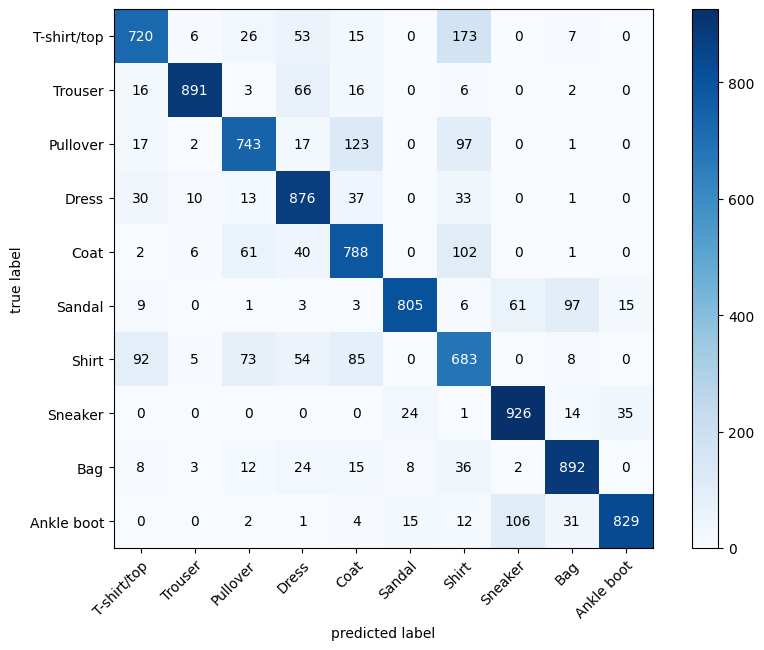

In [152]:
confmat = ConfusionMatrix(num_classes=len(class_names), task="multiclass")
confmat_tensor = confmat(preds=y_pred_tensor, target=test_data.targets)

# Plot  confusion matrix
fig, ax = plot_confusion_matrix(conf_mat=confmat_tensor.numpy(), # matplotlib uses numpy arrays
                                class_names=class_names,
                                figsize=(10,7),
                                colorbar=True)

## Saving model

In [153]:
# Create directory path
DOWNLOAD_PATH = Path("models")
DOWNLOAD_PATH.mkdir(parents=True, exist_ok=True)

# Create model save
MODEL_NAME = "main_model.pth"
MODEL_DOWNLOAD_PATH = DOWNLOAD_PATH / MODEL_NAME

# Save model state dict
print(f"Saving model to: {MODEL_DOWNLOAD_PATH}")
torch.save(obj=main_model.state_dict(), f=MODEL_DOWNLOAD_PATH)

Saving model to: models/main_model.pth
